# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="imagens/liveness.jpg">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and OpenCV.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| CAIQUE DE MOURA VASCONCELOS | rm352508      | 5DTSR |
| DOUGLAS CARVALHO CABRAL | rm352626      | 5DTSR |
| FABIO COELHO DA SILVA | rm352605      | 5DTSR |
| LEONARDO CAETANO DE SIQUEIRA | rm351619      | 5DTSR |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: 

Para deixar o mais preciso possível, resolvemos implementar duas soluções juntas: A identificação de elementos que possam justificar uma tentativa de fraude (como mãos, mais de uma face na câmera) e após passar por essa primeira etapa, a validação através de uma CNN para identificar uma foto de foto.

Algoritmo:
1) Detectar se há somente uma face na captura
2) Detectar se há mãos ou dedos aparentes
3) Passar a imagem para uma CNN

Bases usadas para treinamento e testes durante o desenvolvimento:
https://www.kaggle.com/datasets/minhnh2107/casiafasd
https://www.kaggle.com/datasets/trainingdatapro/antispoofing-replay-dataset
https://www.kaggle.com/datasets/aleksandrpikul222/nuaaaa

Versão do Python que usamos:
**3.9.6**

## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

In [ ]:
!pip install mediapipe

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [3]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Todas as configurações personalizáveis do treino do CNN ficam aqui.
# Fique a vontade para mudar conforme necessidade.

NUMERO_DE_EPOCAS_CNN = 50
NUMERO_PACIENCIA_EPOCAS_CNN = 15
PATH_MELHOR_MODELO_CNN = '_melhor_modelo_cnn/modelo.keras'
BATCH_SIZE_CNN = 256
COMPRAR = 0
VENDER  = 1
IMAGEM_LARGURA = 64
IMAGEM_ALTURA = 64

In [12]:
early_stopping_callback_cnn = EarlyStopping(
    monitor='val_loss',
    min_delta=0.05,  # Mudança mínima considerada como melhoria
    patience=NUMERO_PACIENCIA_EPOCAS_CNN,  # Número de épocas sem melhoria após o qual o treinamento será parado
    verbose=1,
    mode='min',
    restore_best_weights=True  # Restaura os melhores pesos encontrados durante o treinamento
)

In [13]:
model_checkpoint_callback_cnn = ModelCheckpoint(
    filepath=PATH_MELHOR_MODELO_CNN,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [14]:
treino_dir = 'assets/treino'
teste_dir = 'assets/teste'

In [15]:
treino_datagen = ImageDataGenerator(rescale=1.0/255.0)
teste_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [16]:
treino_ds = treino_datagen.flow_from_directory(
    treino_dir,
    target_size=(IMAGEM_ALTURA, IMAGEM_LARGURA),
    batch_size=BATCH_SIZE_CNN,
    #color_mode='grayscale',
    class_mode='binary'
)

teste_ds = teste_datagen.flow_from_directory(
    teste_dir,
    target_size=(IMAGEM_ALTURA, IMAGEM_LARGURA),
    batch_size=BATCH_SIZE_CNN,
    #color_mode='grayscale',
    class_mode='binary'
)

Found 2650 images belonging to 2 classes.
Found 1451 images belonging to 2 classes.


In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGEM_ALTURA, IMAGEM_LARGURA, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 2 classes
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

### 4.2 Treinamento de modelo de liveness (1,5 pontos)

In [18]:
history = model.fit(
    treino_ds,
    validation_data=teste_ds,
    epochs=NUMERO_DE_EPOCAS_CNN,
    callbacks=[early_stopping_callback_cnn, model_checkpoint_callback_cnn]
)

Epoch 1/50


/Users/douglascabral/Library/Mobile Documents/com~apple~CloudDocs/MBA/12-ComputerVision/fiap-ml-visao-computacional-detector-liveness/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.6442 - loss: 0.7299
Epoch 1: val_loss improved from inf to 0.53935, saving model to _melhor_modelo_cnn/modelo.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6463 - loss: 0.7271 - val_accuracy: 0.8622 - val_loss: 0.5393
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6796 - loss: 0.6298
Epoch 2: val_loss improved from 0.53935 to 0.52130, saving model to _melhor_modelo_cnn/modelo.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 902ms/step - accuracy: 0.6801 - loss: 0.6289 - val_accuracy: 0.8622 - val_loss: 0.5213
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6993 - loss: 0.5726
Epoch 3: val_loss improved from 0.52130 to 0.30347, saving model to _melhor_modelo_cnn/modelo.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 867ms/step - accuracy: 0.7013 - loss: 0.5704 - val_accuracy: 0.8608 - val_loss: 0.3035
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.7842 - loss: 0.4680
Epoch 4: val_loss di

### 4.3 Métricas de desempenho do modelo (2 pontos)

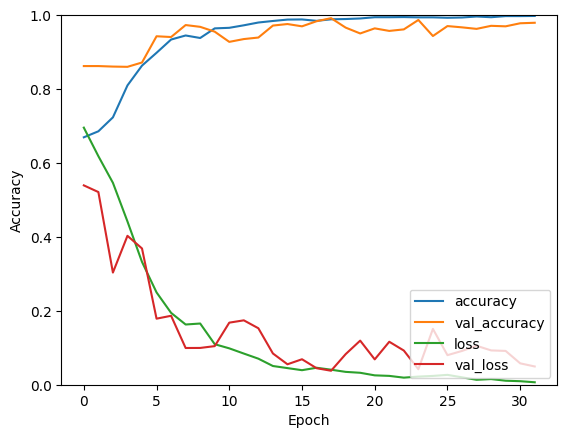

In [19]:
# exibir dados de history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [20]:
model_cnn = load_model(PATH_MELHOR_MODELO_CNN)

true_labels = teste_ds.classes

predictions = model.predict(teste_ds)
predicted_labels = (predictions > 0.5).astype(int).flatten()

loss, accuracy = model_cnn.evaluate(teste_ds)
print("Acurácia do modelo: ", accuracy)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f'Confusion Matrix:\n{conf_matrix}')

precision = precision_score(true_labels, predicted_labels)
print(f'Precision: {precision:.2f}')

recall = recall_score(true_labels, predicted_labels)
print(f'Recall: {recall:.2f}')

f1 = 2 * (precision * recall) / (precision + recall)
print(f'F1-Score: {f1:.2f}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.9912 - loss: 0.0356
Acurácia do modelo:  0.9917298555374146
Confusion Matrix:
[[1070  181]
 [ 171   29]]
Precision: 0.14
Recall: 0.14
F1-Score: 0.14


## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

In [29]:
def prever_imagem(src):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image_read = cv2.imread(src)
    image_rgb = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image_read, cv2.COLOR_BGR2GRAY)

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

    # Detectar faces na imagem
    faces = face_cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    num_faces = len(faces)

    resultados_maos  = hands.process(image_rgb)

    maos_detectadas = resultados_maos.multi_hand_landmarks is not None

    if num_faces == 0 or num_faces > 1 or maos_detectadas:
        print(f"Esta imagem é mais provavelmente: Fake (Maos, sem faces ou mais de uma face detectada)")
        return None

    img = image.load_img(src, target_size=(IMAGEM_ALTURA, IMAGEM_LARGURA))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar a imagem

    prediction = model_cnn.predict(img_array)

    # Porcetagem para cada classe prevista
    porcentagem_real = prediction[0][0] * 100
    porcentagem_fake = (1 - prediction[0][0]) * 100


    classe_prevista = 'Real' if prediction[0] > 0.5 else 'Fake'
    porcentagem = porcentagem_real if classe_prevista == 'Real' else porcentagem_fake
    print(porcentagem)


    print(f"Esta imagem é mais provavelmente: {classe_prevista}")


I0000 00:00:1720377829.229569  143394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-22.5.11), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1720377829.331314  360632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720377829.363788  360632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


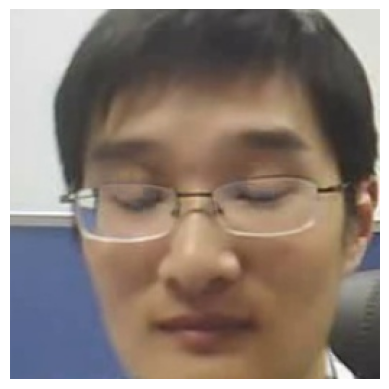

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
98.94775152206421
Esta imagem é mais provavelmente: Real


I0000 00:00:1720377830.006135  143394 gl_context.cc:357] GL version: 2.1 (2.1 INTEL-22.5.11), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1720377830.030821  360670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720377830.054894  360670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


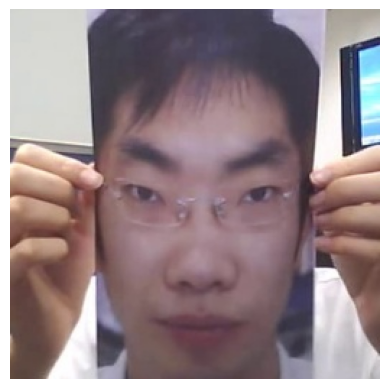

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
99.99923331188256
Esta imagem é mais provavelmente: Fake


In [34]:
prever_imagem('assets/teste/real/11_1.avi_125_real.jpg')
prever_imagem('assets/teste/fake/1_3.avi_50_fake.jpg')


>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pasta streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

Foi usado o streamlit, porém devido o uso do mediapipe que provavelmente depende de GPU ou algo parecido que o Stremlit Cloud não disponibiliza, a versão on-line não funcionou.

[Arquivo do streamlit](../streamlit-app/liveness.py)

Mantivemos o algoritmo na pasta para que possa ser executado localmente. Funciona 100%

Enviamos no portal do aluno o link do vídeo do funcionamento.

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**:

Concluímos que somente o CNN sozinho não é eficaz, é necessário uma combinação de técnicas para uma maior precisão. 

Combinamos em nosso trabalho o uso de HAAR para detecção de faces de forma mais rápida, remoção de elementos desnecessários com o corte da imagem, redimensionamento para 64x64 para um treinamento mais rápido da CNN e predição de novas imagens.

O Streamlit ajuda muito na criação das interfaces gráficas de forma rápida, fazendo que foquemos apenas na solução do problema.

Foi um trabalho de muitos aprendizados, como a necessidade de conversão de RGB p/ BGR em alguns momentos (isso estava afetando na precisão da predição).